In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_formats = ['svg']
import pandas as pd
import numpy as np
from os.path import join, dirname
import h5py
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from tqdm.notebook import tqdm
import seaborn as sns
import itertools
import pickle
%matplotlib inline
import admix

In [2]:
DATA_DIR = "/u/project/pasaniuc/pasaniucdata/admixture/kangcheng/phenotype_simulation/out"
DATASET = "ukb_array/EUR_0.5_AFR_0.5_10_10000"

In [3]:
anc = np.load(join(DATA_DIR, DATASET, "anc.npy"))
phgeno = np.load(join(DATA_DIR, DATASET, "phgeno.npy"))

# subsampling
subset_index = np.arange(0, anc.shape[1], 2000)
anc = anc[:, subset_index]
phgeno = phgeno[:, subset_index]

# form individuals
n_indiv = anc.shape[0] // 2
n_snp = anc.shape[1]
anc = anc.reshape((n_indiv, n_snp * 2))
phgeno = phgeno.reshape((n_indiv, n_snp * 2))

# Simulation

In [4]:
# (var_g, cov)
param_list = [param for param in itertools.product([0.005, 0.01], [0.8, 1.0])]
param_list.append((0.0, 0.0))

In [10]:
n_sim = 50

score_df_dict = dict()
for var_g, cov in param_list:
    print((var_g, cov))
    sim_list = admix.simulate_phenotype_cc_1snp(phgeno, anc, var_g=var_g, cov=cov, n_sim=n_sim, case_prevalence=0.2)
    score_df_list = []
    for snp_i, snp_sim in enumerate(sim_list):
        print('#', end='')
        for sim_i in range(n_sim):
            mix_pheno = snp_sim[2][:, sim_i]
            mix_anc = admix.add_up_haplotype(anc[:, [snp_i, n_snp + snp_i]])
            mix_geno = admix.add_up_haplotype(phgeno[:, [snp_i, n_snp + snp_i]])
            mix_theta = anc.mean(axis=1)
            study_index = admix.sample_case_control(mix_pheno)
            score_df = admix.mixscore_wrapper(pheno=mix_pheno[study_index], 
                                              anc=mix_anc[study_index, :], 
                                              geno=mix_geno[study_index, :], 
                                              theta=mix_theta[study_index])
            tractor_geno = admix.convert_anc_count(anc=anc[:, [snp_i, n_snp + snp_i]], phgeno=phgeno[:, [snp_i, n_snp + snp_i]])
            score_df["TRACTOR"] = admix.tractor(pheno=mix_pheno[study_index],
                                                anc=mix_anc[study_index, :], 
                                                geno=tractor_geno[study_index, :], 
                                                theta=mix_theta[study_index])
            score_df["SIM_I"] = sim_i
            score_df["SNP_I"] = snp_i
            score_df_list.append(score_df)
    score_df_dict[(var_g, cov)] = pd.concat(score_df_list)

(0.005, 0.8)
#################(0.005, 1.0)
#################(0.01, 0.8)
#################(0.01, 1.0)
###########

/u/home/k/kangchen/.local/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


######(0.0, 0.0)
#################

In [5]:
import pickle
# with open("score_df_dict.small_effects.pkl", "wb") as f:
#     pickle.dump(score_df_dict, f)

# with open("score_df_dict.small_effects.pkl", "rb") as f:
#     score_df_dict = pickle.load(f)

# with open("score_df_dict.tractor_added.pkl", "wb") as f:
#     pickle.dump(score_df_dict, f)

with open("score_df_dict.tractor_added.pkl", "rb") as f:
    score_df_dict = pickle.load(f)

# Null simulation

In [6]:
from admix import chi2_to_logpval

/u/local/apps/python/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


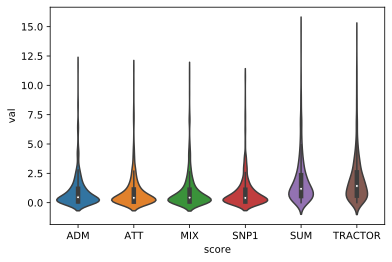

In [7]:
score_df = score_df_dict[(0.0, 0.0)].copy()
melted = score_df.iloc[:, 0:6].melt(var_name="score", value_name="val")
ax = sns.violinplot(x="score", y="val", data=melted)

ADM        0.043529
ATT        0.038824
MIX        0.047059
SNP1       0.034118
SUM        0.049412
TRACTOR    0.048235
dtype: float64


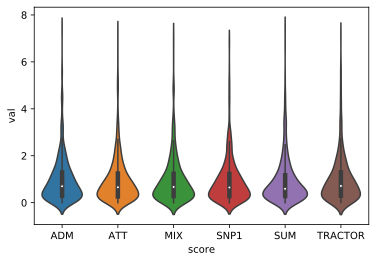

In [8]:
score_df = score_df_dict[(0.0, 0.0)].copy()
score_df.iloc[:, 0:4] = -chi2_to_logpval(score_df.iloc[:, 0:4], dof=1)
score_df.iloc[:, 4:6] = -chi2_to_logpval(score_df.iloc[:, 4:6], dof=2)
melted = score_df.iloc[:, 0:6].melt(var_name="score", value_name="val")
ax = sns.violinplot(x="score", y="val", data=melted)
print(np.mean(score_df.iloc[:, 0:6] > -np.log(0.05), axis=0))

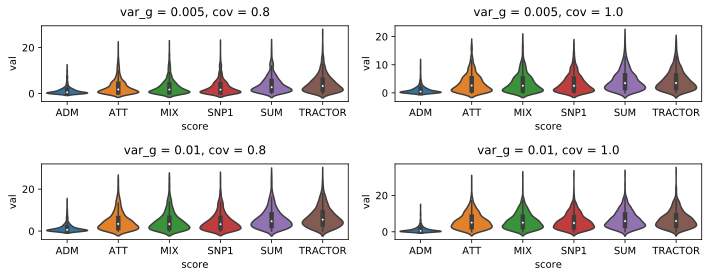

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 4))

for row_i, var_g in enumerate([0.005, 0.01]):
    for col_i, cov in enumerate([0.8, 1.0]):
        score_df = score_df_dict[(var_g, cov)].copy()
        melted = score_df.iloc[:, 0:6].melt(var_name="score", value_name="val")
        sns.violinplot(x="score", y="val", data=melted, ax=axs[(row_i, col_i)], scale="width")
        axs[(row_i, col_i)].set_title(f'var_g = {var_g}, cov = {cov}', y=1.05)
plt.tight_layout()
plt.show()
        

In [12]:
from scipy.stats import ttest_ind

var_g = 0.005, cov = 0.8 Ttest_indResult(statistic=2.9573043517500595, pvalue=0.00314628199040151)
        ADM       ATT   MIX      SNP1       SUM   TRACTOR
0  0.001176  0.037647  0.04  0.035294  0.018824  0.029412
-----
var_g = 0.005, cov = 1.0 Ttest_indResult(statistic=4.877682319514166, pvalue=1.173798721258309e-06)
        ADM       ATT       MIX      SNP1       SUM   TRACTOR
0  0.001176  0.035294  0.031765  0.032941  0.017647  0.017647
-----
var_g = 0.01, cov = 0.8 Ttest_indResult(statistic=3.2903806993431757, pvalue=0.0010210173483453625)
        ADM       ATT  MIX      SNP1       SUM   TRACTOR
0  0.005882  0.101176  0.1  0.091765  0.071765  0.089412
-----
var_g = 0.01, cov = 1.0 Ttest_indResult(statistic=5.846017428328482, pvalue=6.024978065148893e-09)
        ADM       ATT       MIX      SNP1       SUM   TRACTOR
0  0.001176  0.142353  0.142353  0.136471  0.085882  0.083529
-----


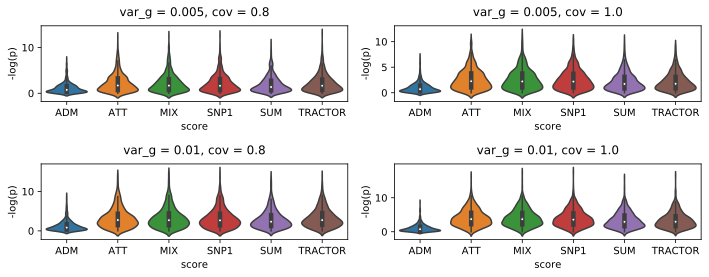

In [13]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 4))

for row_i, var_g in enumerate([0.005, 0.01]):
    for col_i, cov in enumerate([0.8, 1.0]):
        score_df = score_df_dict[(var_g, cov)].copy()
        score_df.iloc[:, 0:4] = -chi2_to_logpval(score_df.iloc[:, 0:4], dof=1)
        score_df.iloc[:, 4:6] = -chi2_to_logpval(score_df.iloc[:, 4:6], dof=2)
        melted = score_df.iloc[:, 0:6].melt(var_name="score", value_name="-log(p)")
        sns.violinplot(x="score", y="-log(p)", data=melted, ax=axs[(row_i, col_i)], scale="width")
        axs[(row_i, col_i)].set_title(f'var_g = {var_g}, cov = {cov}', y=1.05)
        print(f"var_g = {var_g}, cov = {cov}", ttest_ind(score_df.MIX, score_df.SUM, nan_policy="omit"))
        print(pd.DataFrame(np.mean(score_df.iloc[:, 0:6] > -np.log(1e-3), axis=0)).T)
        print('-----')
plt.tight_layout()
plt.show()

# Deprecated below

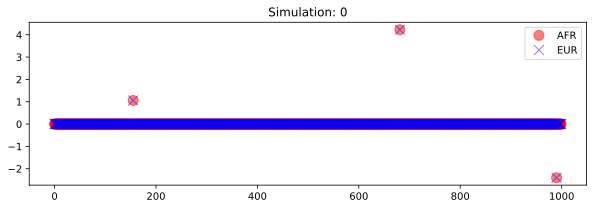

In [16]:
haplo_index0 = np.arange(n_snp)
haplo_index1 = np.arange(n_snp) + n_snp

plt.figure(figsize=(10, 3))
sim_i = 0
sim_beta = beta[:, sim_i]
sim_phe = phe[:, sim_i]

plt.plot(np.arange(n_snp), sim_beta[haplo_index0], 'ro', alpha=0.5, label="AFR", markersize=10)
plt.plot(np.arange(n_snp), sim_beta[haplo_index1], 'bx', alpha=0.5, label="EUR", markersize=10)
plt.title(f'Simulation: {sim_i}')
plt.legend()

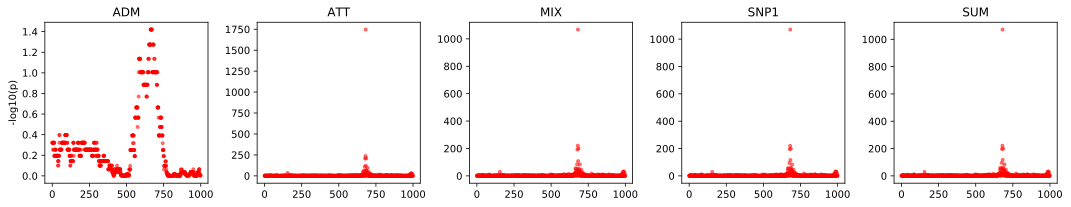

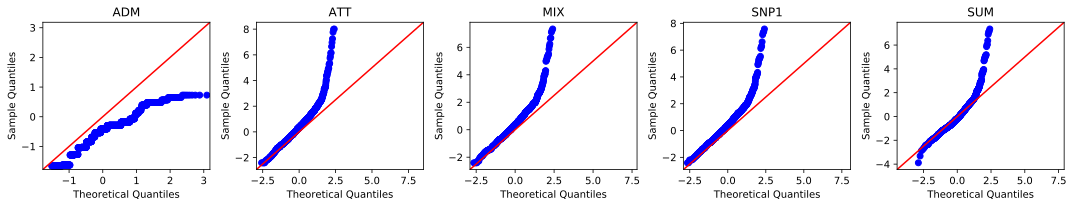

In [18]:
pval_fig, pval_axs = plt.subplots(1, score_df.shape[1], figsize=(15,3))
qq_fig, qq_axs = plt.subplots(1, score_df.shape[1], figsize=(15,3))
for col_i, col in enumerate(score_df.columns):
    df = 2 if col == "SUM" else 1
    pval = pval2zsc(1. - stats.chi2.cdf(score_df[col].values, df=df))
    pval_axs[col_i].plot(np.arange(n_snp), score_df[col].values, 'r.', alpha=0.5)
    pval_axs[col_i].set_title(score_df.columns[col_i])
    sm.qqplot(pval, line="45", ax=qq_axs[col_i])
    qq_axs[col_i].set_title(score_df.columns[col_i])

pval_axs[0].set_ylabel("-log10(p)")
pval_fig.tight_layout()
pval_fig.show()
qq_fig.tight_layout()
qq_fig.show()